# Exploratory Data Analysis (EDA)

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### UDFs

In [2]:
def count_plot(x, dataframe, ax=None, **kwargs):
    if len(kwargs)==1 and kwargs['mode']=='horizontal':
        sns.countplot(y=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    else:
        sns.countplot(x=x, data=dataframe, ax=ax, order=dataframe[x].value_counts().index)
    plt.box(False)
    return None

    
def pie_plot(df_col, fig_size, title):
    fig, ax = plt.subplots(figsize=fig_size)
    ax.pie(df_col.values, autopct='%1.2f%%', shadow=False, startangle=90)
    ax.axis('equal')
    plt.legend(labels=df_col.index, bbox_to_anchor=(1.05, 1))
    plt.title(title)
    plt.show()
    return None


def stacked_vBar_plot(dataframe, value, index, column, xlabel, fig_size, scale='linear', with_percent=True):
    
    df_1 = dataframe.pivot_table(values=[value], index=[index], columns=[column], aggfunc=len, margins=True)
    df_1_percent = df_1.div(df_1.iloc[:,-1], axis=0).mul(100, axis=0).round(2)
    df_2_percent = df_1_percent.iloc[:, :-1].drop('All')
    
    columns = df_2_percent.columns.levels[1].tolist()
    columns.remove('All')
    
    ax = df_2_percent.plot.bar(stacked=True)
    ax.figure.set_size_inches(fig_size)
    ax.grid(False)
    plt.legend(labels=columns, bbox_to_anchor=(1.05, 1), title='NPS Type')
    plt.xlabel(xlabel)
    plt.ylabel('%GT Count of NPS_Type')
    
    if with_percent:
        # Add this loop to add the annotations
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate('{:.2f}%'.format(height), (x + width/8, y + height/2))
    plt.box(False)
    plt.show()
    return None


def pdf_distribution_plots(df, features, target):
    nrow = int((len(features)/3) + len(features)%3)
    
    t0 = df.loc[df[target] == 0]
    t1 = df.loc[df[target] == 1]

    sns.set_style('whitegrid')
    fig = plt.figure(figsize=(15,10))

    for indx, feature in enumerate(features):
        ax = fig.add_subplot(nrow, 3, indx+1)
        sns.kdeplot(t0[feature], label="0", legend=True)
        sns.kdeplot(t1[feature], label="1", legend=True)
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel(feature, fontsize=12)
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.legend(loc='best')
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None,wspace= 0.3, hspace=0.5)
    plt.show()
    return None


def clipping(dataframe, num_cols):
    df_copy = dataframe.copy()
    for col in num_cols:
        p25 = np.percentile(df_copy[col], 25)
        p75 = np.percentile(df_copy[col], 75)
        iqr = p75 - p25
        df_copy[col] = np.clip(df_copy[col], a_min=(p25 - 1.5*iqr), a_max=(p75 + 1.5*iqr))
    return df_copy


def get_category(df, col, binsnum, labels, qcut = False):
    if qcut:
        localdf = pd.qcut(df[col], q = binsnum, labels = labels) # quantile cut
    else:
        localdf = pd.cut(df[col], bins = binsnum, labels = labels) # equal-length cut
        
    localdf = pd.DataFrame(localdf)
    name = col + '_CAT'
    localdf[name] = localdf[col]
    df = df.join(localdf[name])
    df[name] = df[name].astype(object)
    return df

### Configurations

In [3]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

### Load Datasets

In [4]:
application_df = pd.read_csv('./data/application_record.csv')

application_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
credit_df = pd.read_csv('./data/credit_record.csv')

credit_df.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [6]:
print("Application dataset shape: {}".format(application_df.shape))
print("Credit dataset shape: {}".format(credit_df.shape))

Application dataset shape: (438557, 18)
Credit dataset shape: (1048575, 3)


In [7]:
print("Unique IDs in application dataset: {}".format(len(set(application_df['ID']))))

Unique IDs in application dataset: 438510


In [8]:
print("Unique IDs in credit dataset: {}".format(len(set(credit_df['ID']))))

Unique IDs in credit dataset: 45985


In [9]:
print("Common IDs in both datasets: {}".format(len(set(application_df['ID']).intersection(set(credit_df['ID'])))))

Common IDs in both datasets: 36457


##### Drop Duplicated IDs

In [10]:
ids = application_df["ID"]

app_df_dup = application_df[ids.isin(ids[ids.duplicated()])].sort_values("ID")

app_df_dup.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
426488,7023108,F,N,N,0,135000.0,Working,Secondary / secondary special,Married,House / apartment,-17590,-1273,1,0,0,0,Cleaning staff,2.0
425306,7023651,F,N,N,0,225000.0,Commercial associate,Incomplete higher,Single / not married,House / apartment,-10229,-1209,1,0,0,0,Accountants,1.0
421907,7023651,M,Y,N,1,157500.0,Commercial associate,Incomplete higher,Married,House / apartment,-10521,-1457,1,0,0,0,Drivers,3.0
427778,7024111,M,N,N,2,157500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-15270,-117,1,1,0,0,Drivers,4.0
432643,7024111,F,N,Y,0,180000.0,Working,Secondary / secondary special,Married,House / apartment,-22041,-1524,1,1,1,0,Accountants,2.0


In [11]:
application_df = application_df.drop_duplicates(subset='ID')

print("Application dataset shape: {}".format(application_df.shape))

Application dataset shape: (438510, 18)


In [12]:
application_df.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134193
CNT_FAM_MEMBERS             0
dtype: int64

In [13]:
application_df.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [14]:
credit_df.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [15]:
credit_df.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

### Target Label Creation

In order to identify *high risk* and *low risk* credit users below method is used.

- **High Risk (Class 1):** If during any month, user is late on payments by 30 days or more.
- **Low Risk (Class 0):** If the user has paid off, no loan taken or 1-29 days past due during any month

In [16]:
credit_df['target_status'] = np.where((credit_df['STATUS']=='0')|(credit_df['STATUS']=='C')|(credit_df['STATUS']=='X'), 0, 1)

# target=1 (high risk) iff there is at least one month where user is late on payments by 30 days or more
target_df=pd.DataFrame(credit_df.groupby(['ID'])['target_status'].agg(max)).reset_index()

target_df.head()

,ID,target_status
0,5001711,0
1,5001712,0
2,5001713,0
3,5001714,0
4,5001715,0


In [17]:
target_df.groupby('target_status')['ID'].count()

target_status
0    40635
1     5350
Name: ID, dtype: int64

In [18]:
target_df['target_status'].value_counts(normalize=True)

0    0.883658
1    0.116342
Name: target_status, dtype: float64

In [19]:
# Merge target label to application dataset
merged_df = pd.merge(application_df, target_df, how='inner', on='ID')

merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target_status
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0


In [20]:
merged_df['target_status'] = merged_df['target_status'].astype("category")

In [21]:
merged_df.shape

(36457, 19)

### Data Pre-processing

In [22]:
merged_df['ID'].nunique()

36457

In [23]:
merged_df.isna().sum()

ID                         0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_MOBIL                 0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
target_status              0
dtype: int64

In [24]:
merged_df['OCCUPATION_TYPE'].value_counts()

Laborers                 6211
Core staff               3591
Sales staff              3485
Managers                 3012
Drivers                  2138
High skill tech staff    1383
Accountants              1241
Medicine staff           1207
Cooking staff             655
Security staff            592
Cleaning staff            551
Private service staff     344
Low-skill Laborers        175
Waiters/barmen staff      174
Secretaries               151
HR staff                   85
Realty agents              79
IT staff                   60
Name: OCCUPATION_TYPE, dtype: int64

In [25]:
merged_df['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

merged_df.isna().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
target_status          0
dtype: int64

In [26]:
merged_df.dtypes

ID                        int64
CODE_GENDER              object
FLAG_OWN_CAR             object
FLAG_OWN_REALTY          object
CNT_CHILDREN              int64
AMT_INCOME_TOTAL        float64
NAME_INCOME_TYPE         object
NAME_EDUCATION_TYPE      object
NAME_FAMILY_STATUS       object
NAME_HOUSING_TYPE        object
DAYS_BIRTH                int64
DAYS_EMPLOYED             int64
FLAG_MOBIL                int64
FLAG_WORK_PHONE           int64
FLAG_PHONE                int64
FLAG_EMAIL                int64
OCCUPATION_TYPE          object
CNT_FAM_MEMBERS         float64
target_status          category
dtype: object

##### Feature Engineering

In [27]:
merged_df = get_category(merged_df, col='AMT_INCOME_TOTAL', binsnum=3, labels=["low","medium", "high"], qcut = True)

merged_df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,target_status,AMT_INCOME_TOTAL_CAT
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Other,2.0,1,high
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Other,2.0,1,high
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0,low
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,high
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0,high


##### Data Transformation

In [28]:
merged_df['NAME_EDUCATION_TYPE'].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [29]:
merged_df['DAYS_BIRTH'] = -1 * merged_df['DAYS_BIRTH']

merged_df['DAYS_EMPLOYED'] = -1 * merged_df['DAYS_EMPLOYED']
merged_df['DAYS_EMPLOYED'] = np.where((merged_df['DAYS_EMPLOYED']<=0), 0, merged_df['DAYS_EMPLOYED'])

merged_df['NAME_EDUCATION_TYPE_ENCODED'] = merged_df['NAME_EDUCATION_TYPE'].replace({'Lower secondary': 0,
                                                                                     'Secondary / secondary special': 1,
                                                                                     'Incomplete higher': 2,
                                                                                     'Higher education': 3,
                                                                                     'Academic degree': 4})

In [30]:
cat_features = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                'NAME_HOUSING_TYPE', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'AMT_INCOME_TOTAL_CAT']

num_features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

all_features = num_features + cat_features

##### Statistics

In [31]:
merged_df['CNT_FAM_MEMBERS'] = merged_df['CNT_FAM_MEMBERS'].astype(int)

In [32]:
merged_df[num_features].describe().applymap('{:,.2f}'.format)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
count,"36,457.00","36,457.00","36,457.00","36,457.00","36,457.00"
mean,0.43,"186,685.74","15,975.17","2,200.32",2.20
std,0.74,"101,789.23","4,200.55","2,366.80",0.91
min,0.00,"27,000.00","7,489.00",0.00,1.00
25%,0.00,"121,500.00","12,462.00",408.00,2.00
50%,0.00,"157,500.00","15,563.00","1,552.00",2.00
75%,1.00,"225,000.00","19,438.00","3,153.00",3.00
max,19.00,"1,575,000.00","25,152.00","15,713.00",20.00


In [33]:
merged_df[cat_features] = merged_df[cat_features].astype("category")
merged_df[cat_features].describe()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,AMT_INCOME_TOTAL_CAT
count,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457,36457
unique,2,2,2,5,5,5,6,1,2,2,2,19,3
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Other,low
freq,24430,22614,24506,18819,24777,25048,32548,36457,28235,25709,33186,11323,14473


##### Outlier Handling

In [34]:
handle_outliers = 'yes'

if handle_outliers=='yes':
    merged_df = clipping(dataframe=merged_df, num_cols=num_features)
elif handle_outliers=='no':
    merged_df = merged_df

### Data Visualization - Univariate Analysis

##### Target label

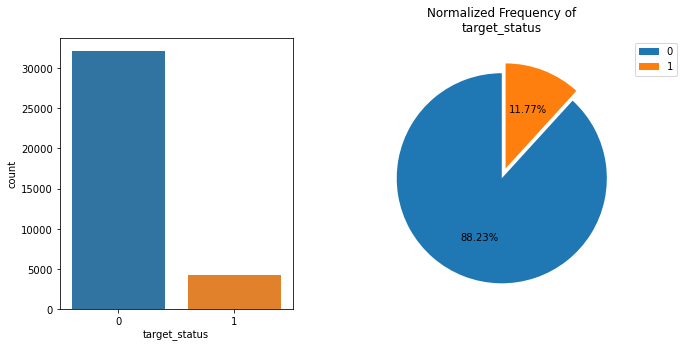

In [35]:
feature = 'target_status'
unique_id = 'ID'

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### CODE_GENDER

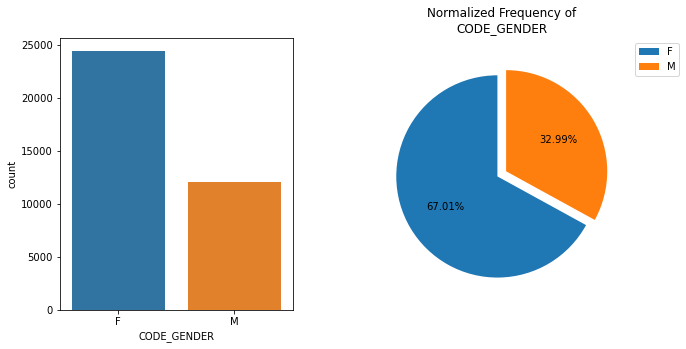

In [36]:
feature = 'CODE_GENDER'
unique_id = 'ID'

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_OWN_CAR

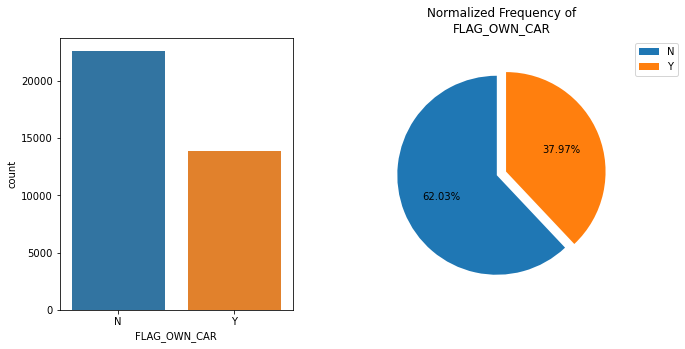

In [37]:
feature = 'FLAG_OWN_CAR'
unique_id = 'ID'

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_OWN_REALTY

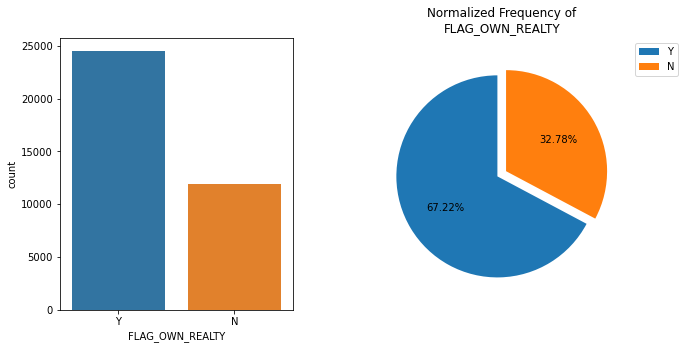

In [38]:
feature = 'FLAG_OWN_REALTY'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### NAME_INCOME_TYPE

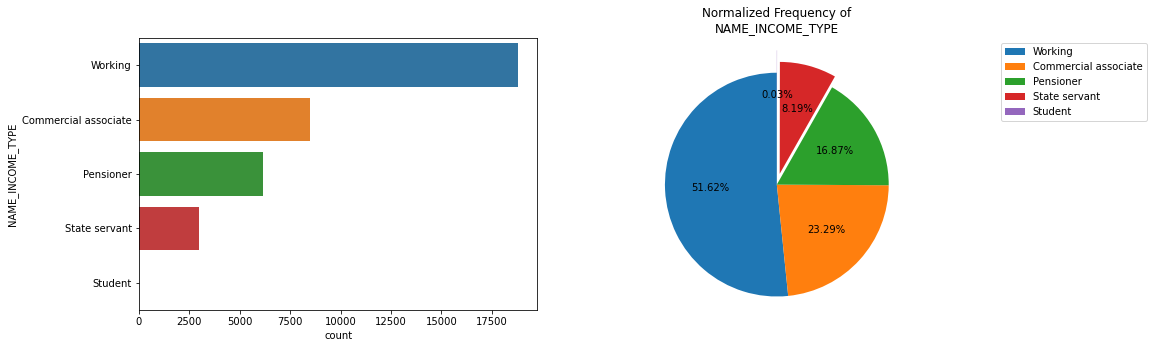

In [39]:
feature = 'NAME_INCOME_TYPE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(15,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.1)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0], mode='horizontal')

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0, 0.1, 0.2))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### NAME_EDUCATION_TYPE

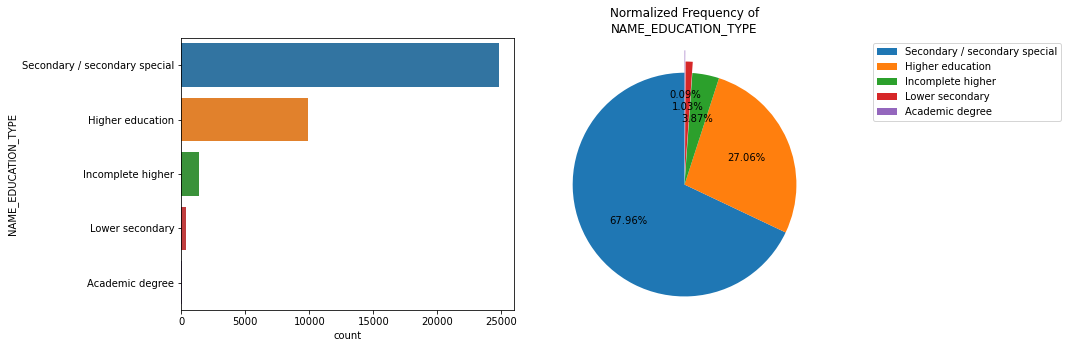

In [40]:
feature = 'NAME_EDUCATION_TYPE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.01)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0], mode='horizontal')

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0, 0.1, 0.2))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### NAME_FAMILY_STATUS

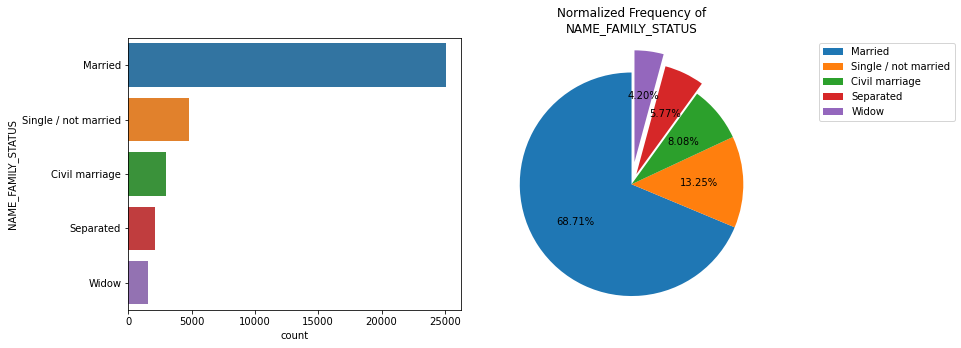

In [41]:
feature = 'NAME_FAMILY_STATUS'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(12,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.01)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0], mode='horizontal')

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0, 0.1, 0.2))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### NAME_HOUSING_TYPE

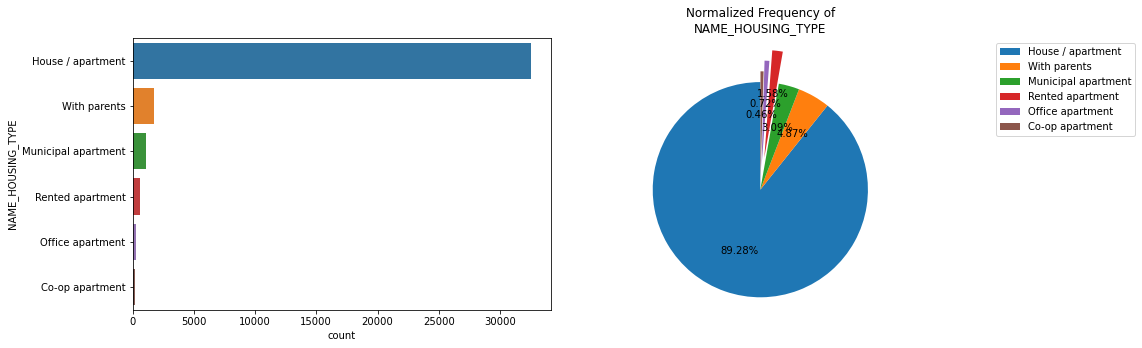

In [42]:
feature = 'NAME_HOUSING_TYPE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(15,5))
fig1.subplots_adjust(hspace=0.4, wspace=0)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0], mode='horizontal')

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0, 0.3, 0.2, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_MOBIL

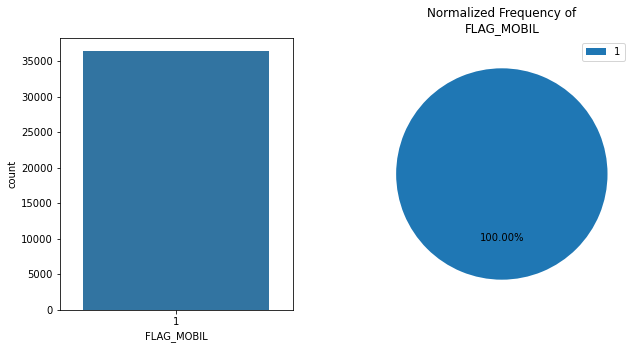

In [43]:
feature = 'FLAG_MOBIL'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_WORK_PHONE

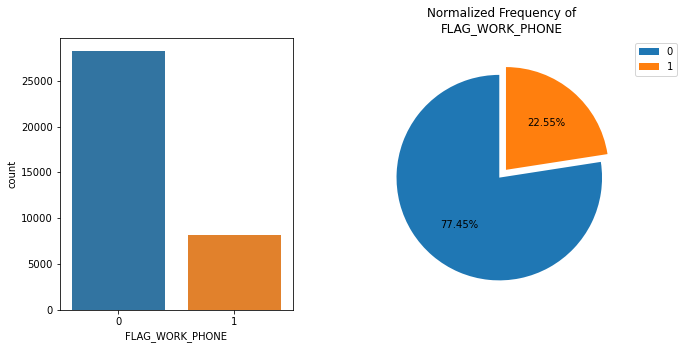

In [44]:
feature = 'FLAG_WORK_PHONE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_PHONE

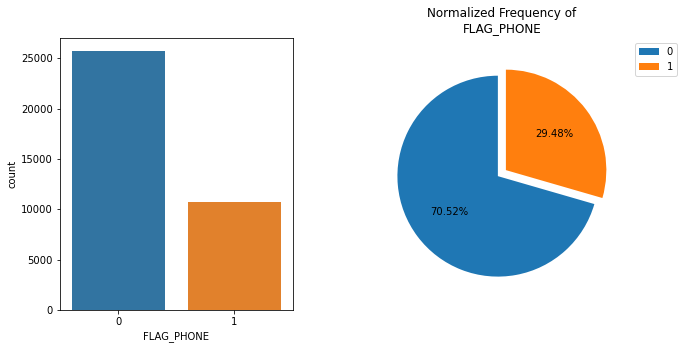

In [45]:
feature = 'FLAG_PHONE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### FLAG_EMAIL

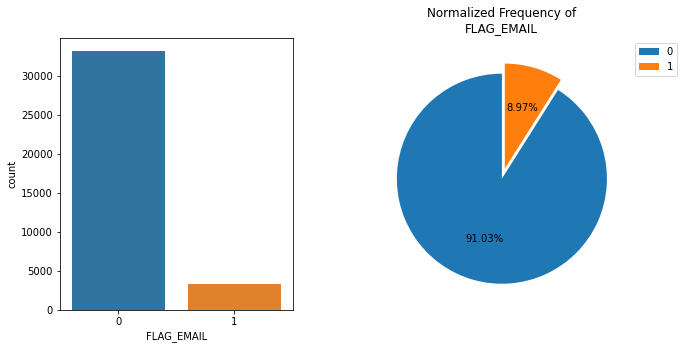

In [46]:
feature = 'FLAG_EMAIL'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### OCCUPATION_TYPE

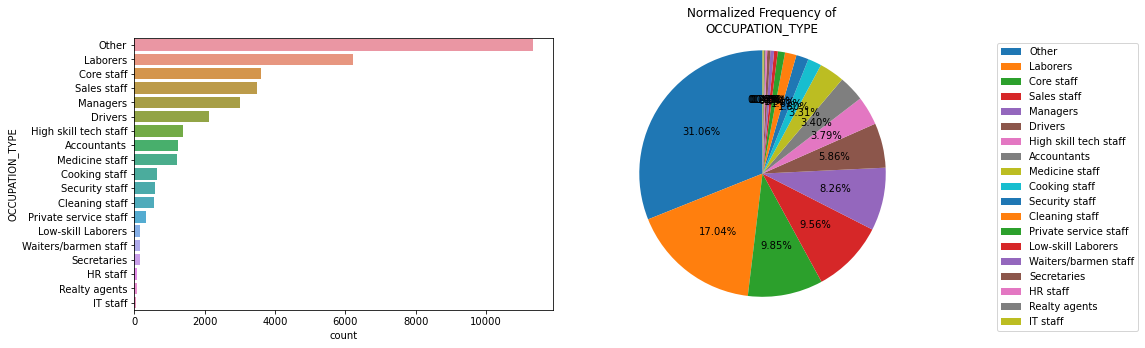

In [47]:
feature = 'OCCUPATION_TYPE'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(15,5))
fig1.subplots_adjust(hspace=0.4, wspace=0)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0], mode='horizontal')

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90)
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

##### AMT_INCOME_TOTAL_CAT

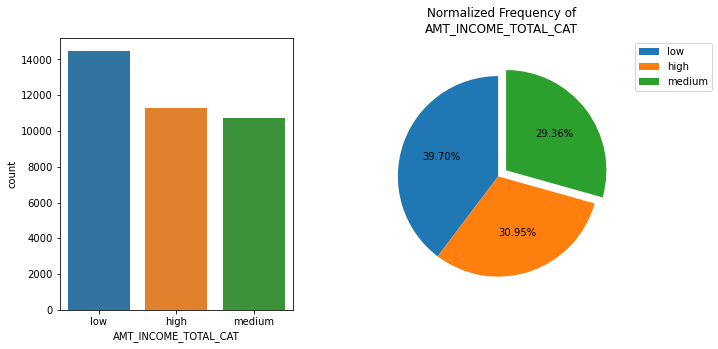

In [48]:
feature = 'AMT_INCOME_TOTAL_CAT'
unique_id = 'ID' 

fig1, axes1 = plt.subplots(1, 2, figsize=(10,5))
fig1.subplots_adjust(hspace=0.4, wspace=0.4)

count_plot(x=feature, dataframe=merged_df, ax=axes1[0])

target_status_df = merged_df.groupby([feature])[[unique_id]].count()
target_status_df.rename(columns={unique_id: 'Count'}, inplace=True)
target_status_df['Percentage'] = round(100*target_status_df['Count']/target_status_df['Count'].sum(), 2)
target_status_df.sort_values(by=['Percentage'], ascending=False, inplace=True)

axes1[1].pie(target_status_df['Count'].values, autopct='%1.2f%%', shadow=False, startangle=90, explode=(0, 0, 0.1))
axes1[1].axis('equal')
axes1[1].legend(labels=target_status_df['Count'].index, bbox_to_anchor=(1.05, 1))
axes1[1].title.set_text('Normalized Frequency of\n{}'.format(feature))

plt.show()

#### Histograms

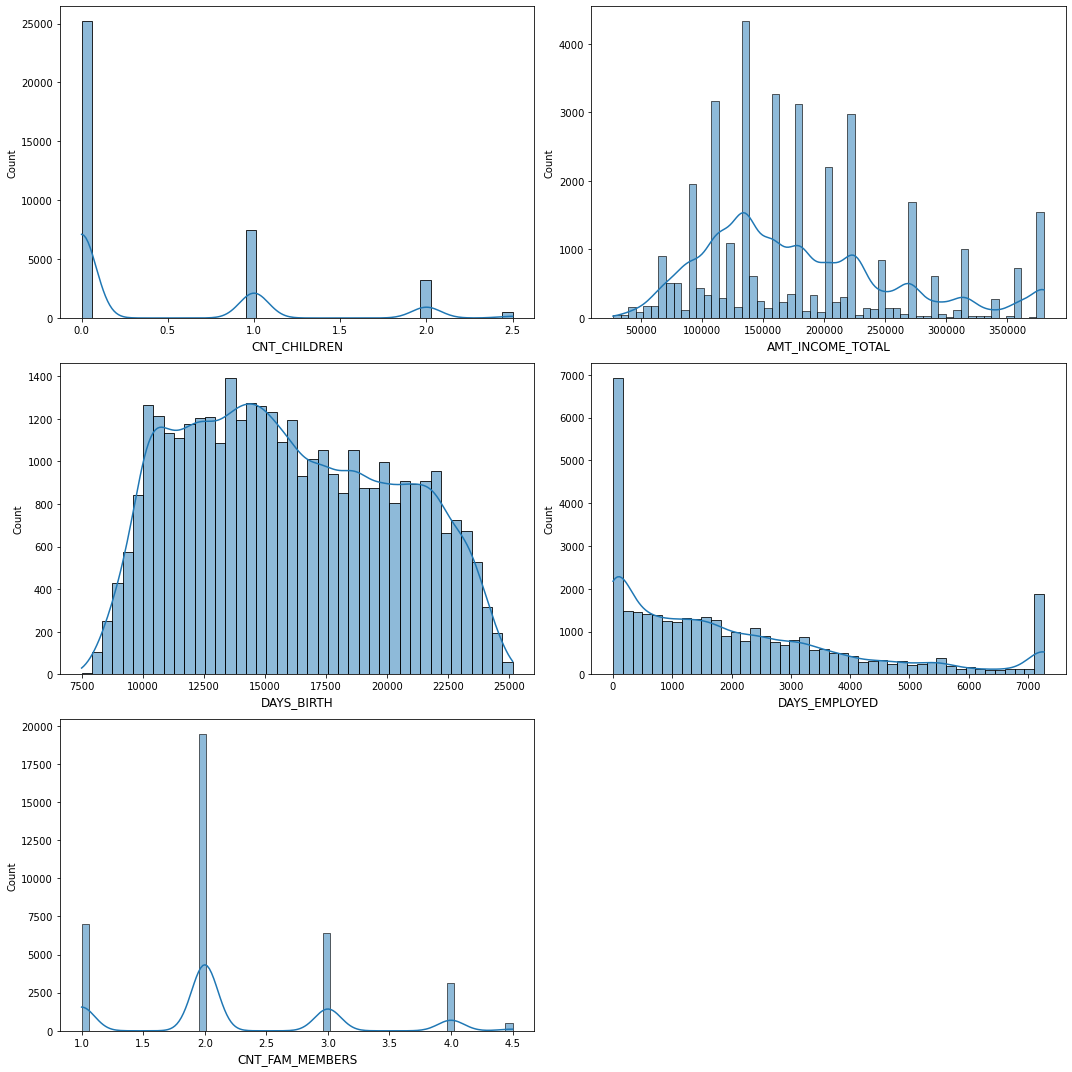

In [49]:
nrow = int((len(num_features)/2) + len(num_features)%2)
#nrow = int(len(num_features))

fig = plt.figure(figsize=(15,15))

for i, feature in enumerate(num_features):
    ax = fig.add_subplot(nrow, 2, i+1)
    sns.histplot(data=merged_df, x=feature, kde=True)
    ax.set_xlabel(feature, fontsize=12)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

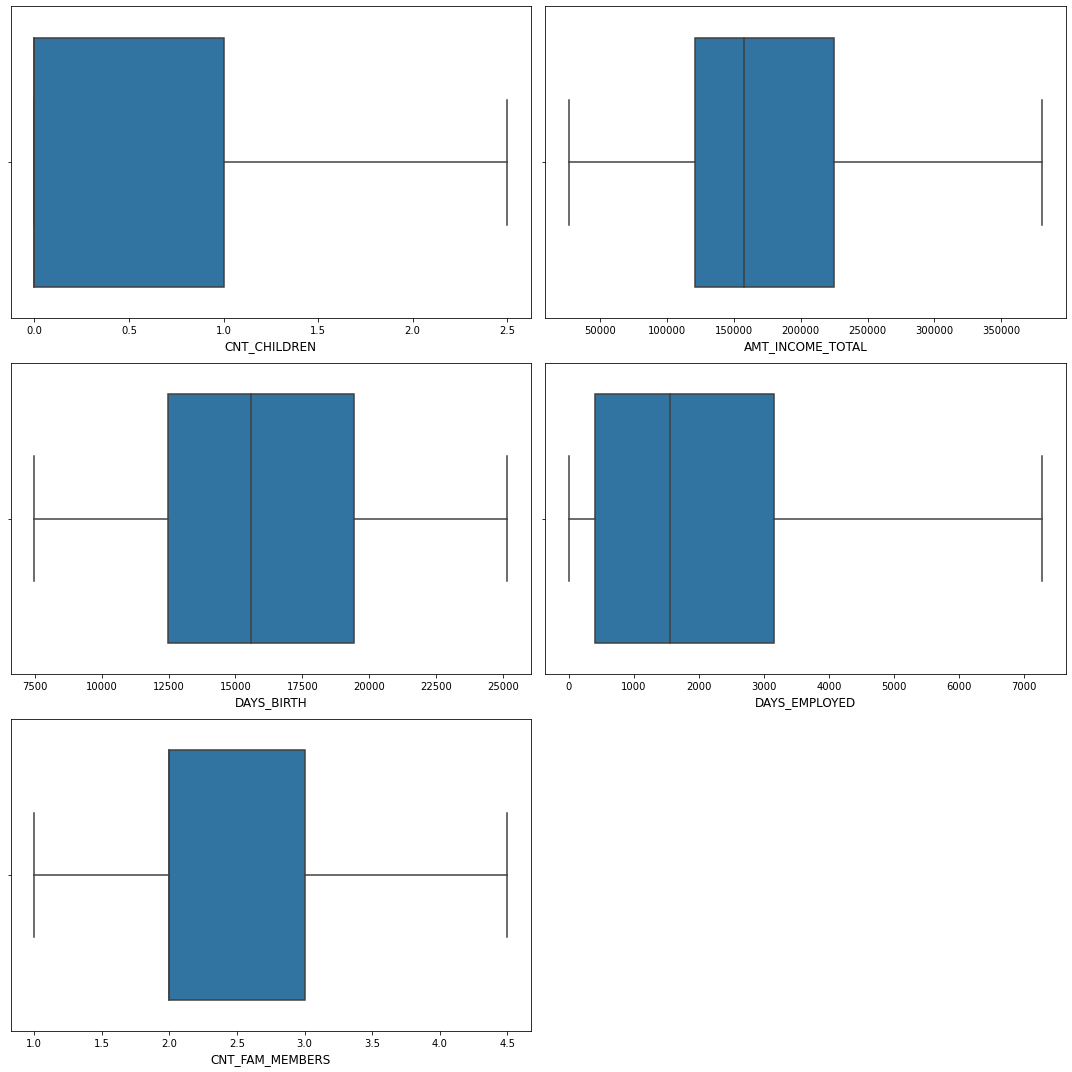

In [50]:
nrow = int((len(num_features)/2) + len(num_features)%2)
#nrow = int(len(num_features))

fig = plt.figure(figsize=(15,15))

for i, feature in enumerate(num_features):
    ax = fig.add_subplot(nrow, 2, i+1)
    sns.boxplot(data=merged_df, x=feature)
    ax.set_xlabel(feature, fontsize=12)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

### Data Visualization - Bivariate Analysis

#### Histograms

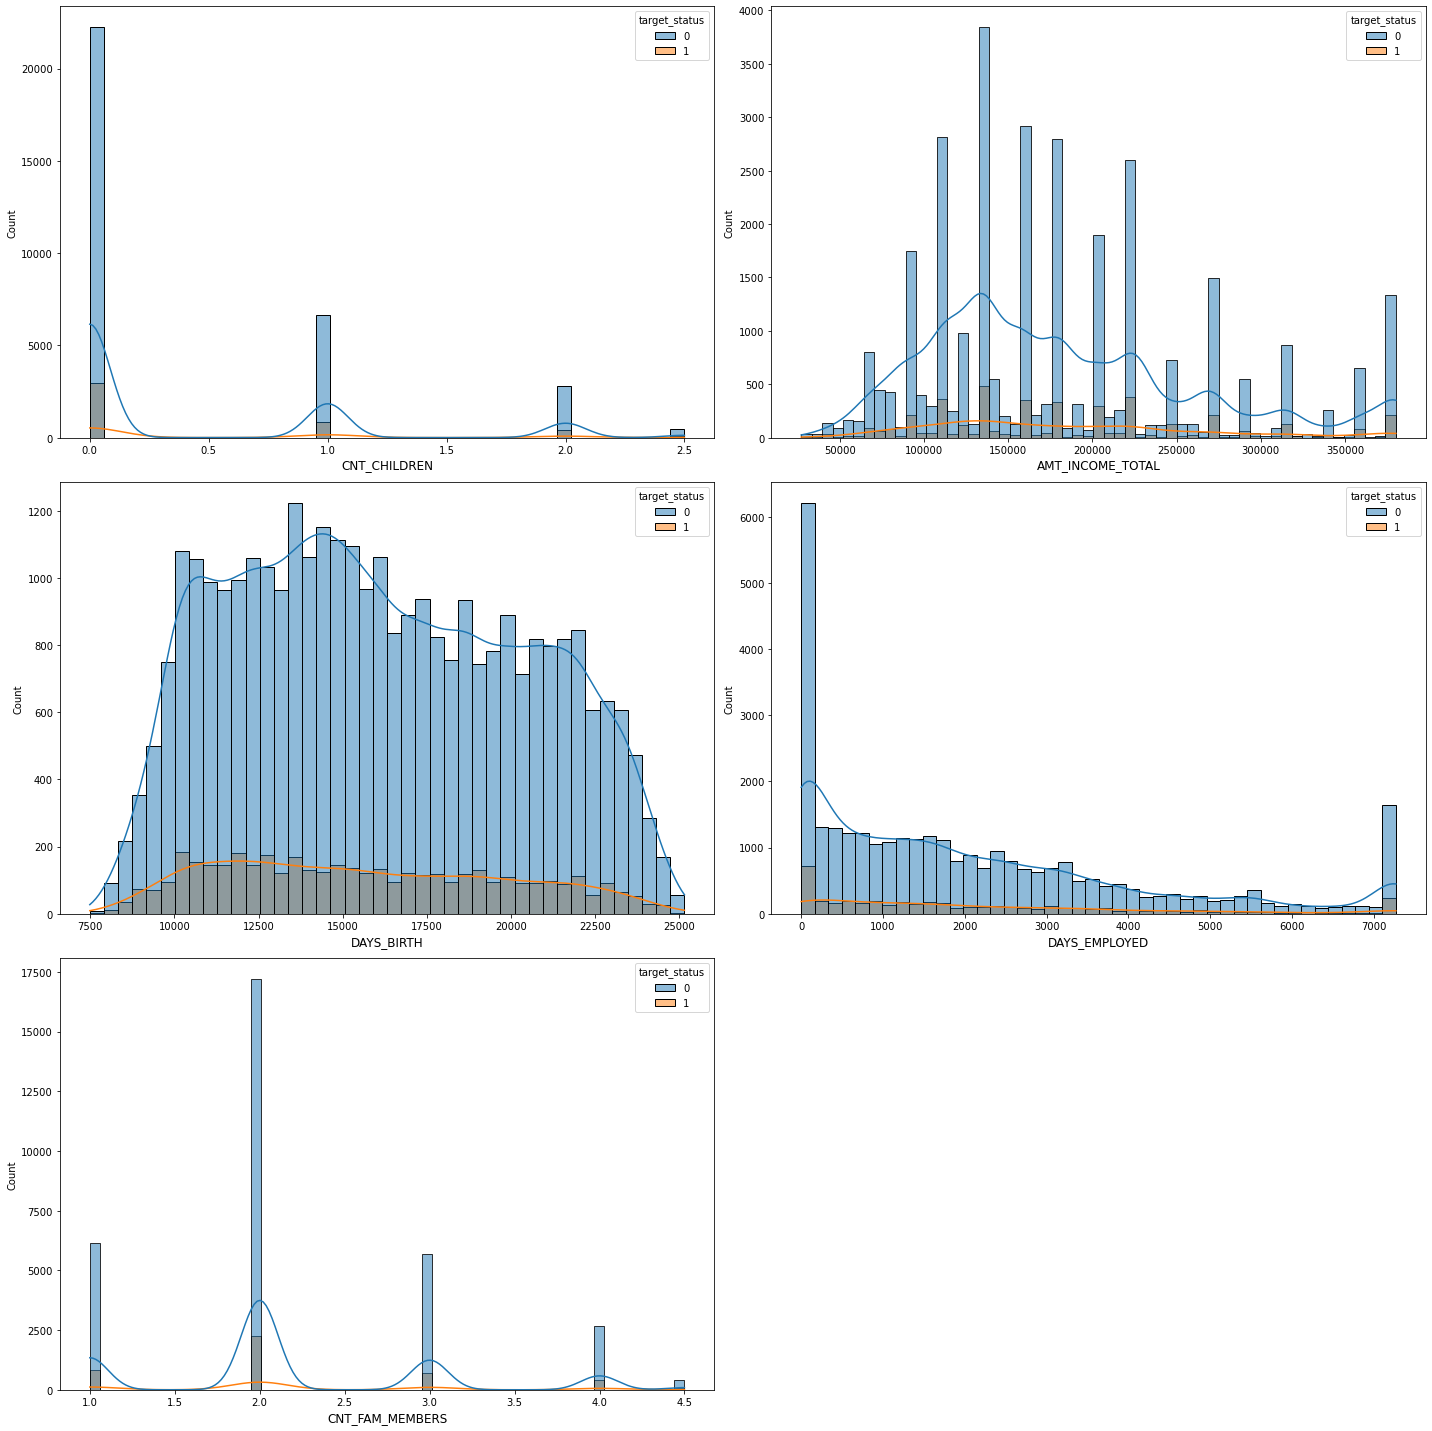

In [51]:
nrow = int((len(num_features)/2) + len(num_features)%2)
#nrow = int(len(num_features))

fig = plt.figure(figsize=(20,20))

for i, feature in enumerate(num_features):
    ax = fig.add_subplot(nrow, 2, i+1)
    sns.histplot(data=merged_df, x=feature, hue='target_status', kde=True)
    ax.set_xlabel(feature, fontsize=12)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

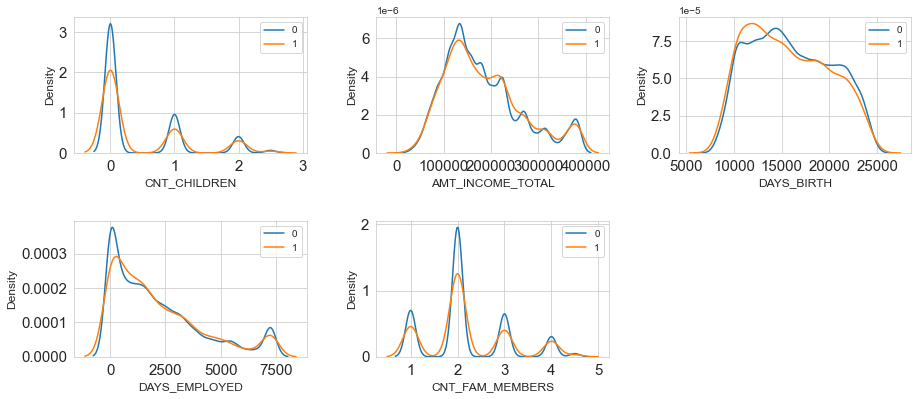

In [52]:
pdf_distribution_plots(df=merged_df, features=num_features, target='target_status')
plt.show()

##### Boxplots

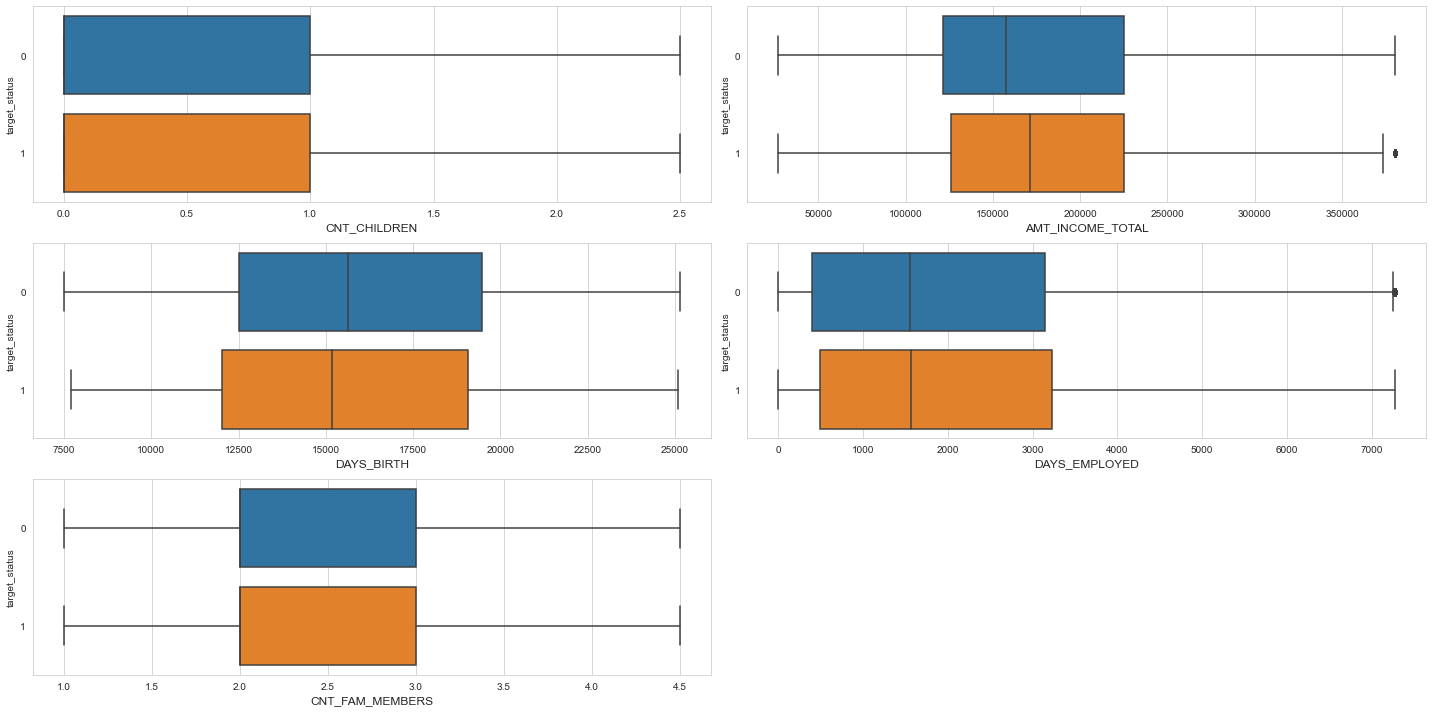

In [53]:
nrow = int((len(num_features)/2) + len(num_features)%2)
#nrow = int(len(num_features))

fig = plt.figure(figsize=(20,10))

for i, feature in enumerate(num_features):
    ax = fig.add_subplot(nrow, 2, i+1)
    sns.boxplot(data=merged_df, x=feature, y="target_status")
    ax.set_xlabel(feature, fontsize=12)

# Adjust the spacing between subplots
fig.tight_layout()

# Display the plot
plt.show()

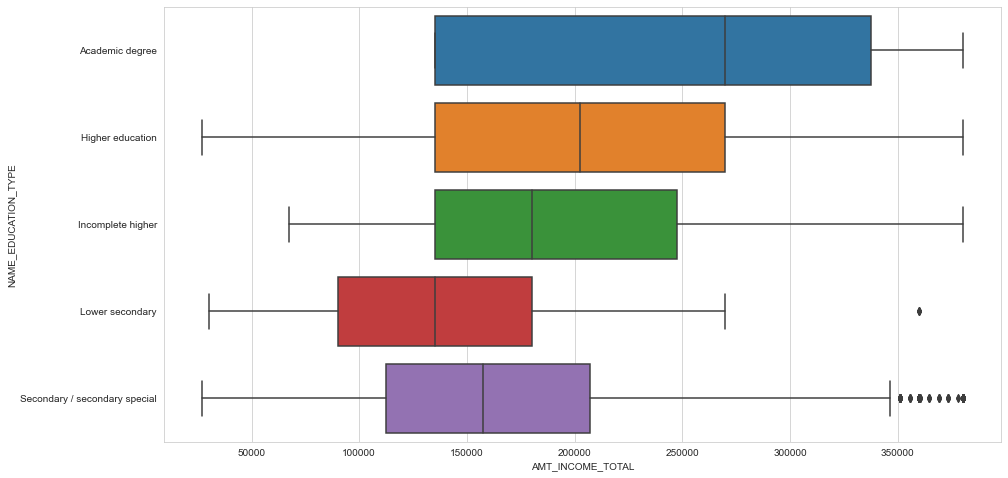

In [54]:
fig = plt.figure(figsize=(15,8))

sns.boxplot(data=merged_df, x="AMT_INCOME_TOTAL", y="NAME_EDUCATION_TYPE")

plt.show()

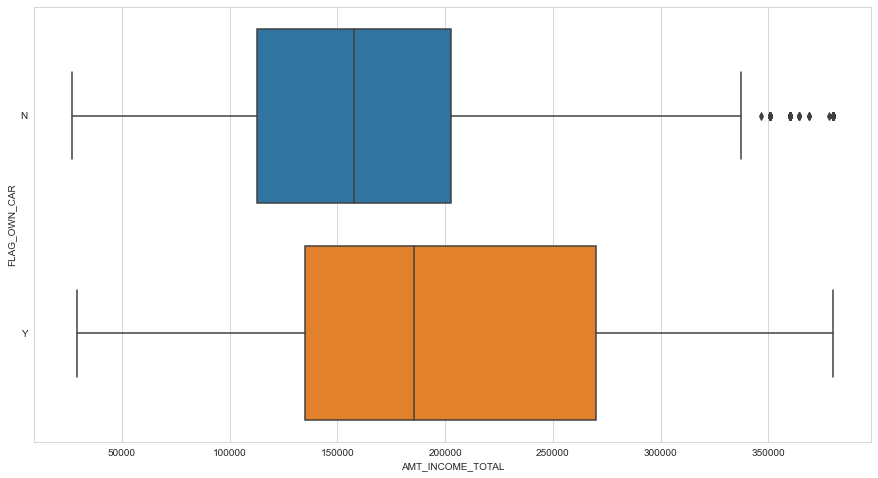

In [55]:
fig = plt.figure(figsize=(15,8))

sns.boxplot(data=merged_df, x="AMT_INCOME_TOTAL", y="FLAG_OWN_CAR")

plt.show()

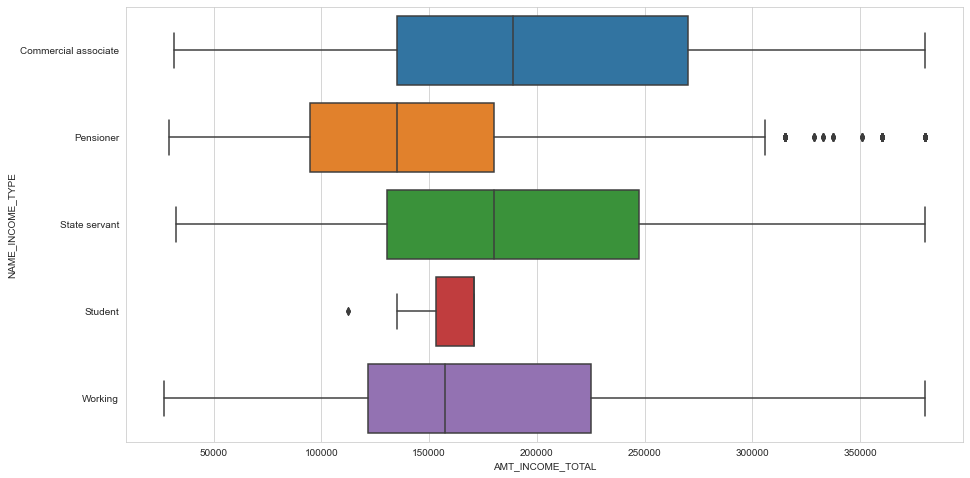

In [56]:
fig = plt.figure(figsize=(15,8))

sns.boxplot(data=merged_df, x="AMT_INCOME_TOTAL", y="NAME_INCOME_TYPE")

plt.show()

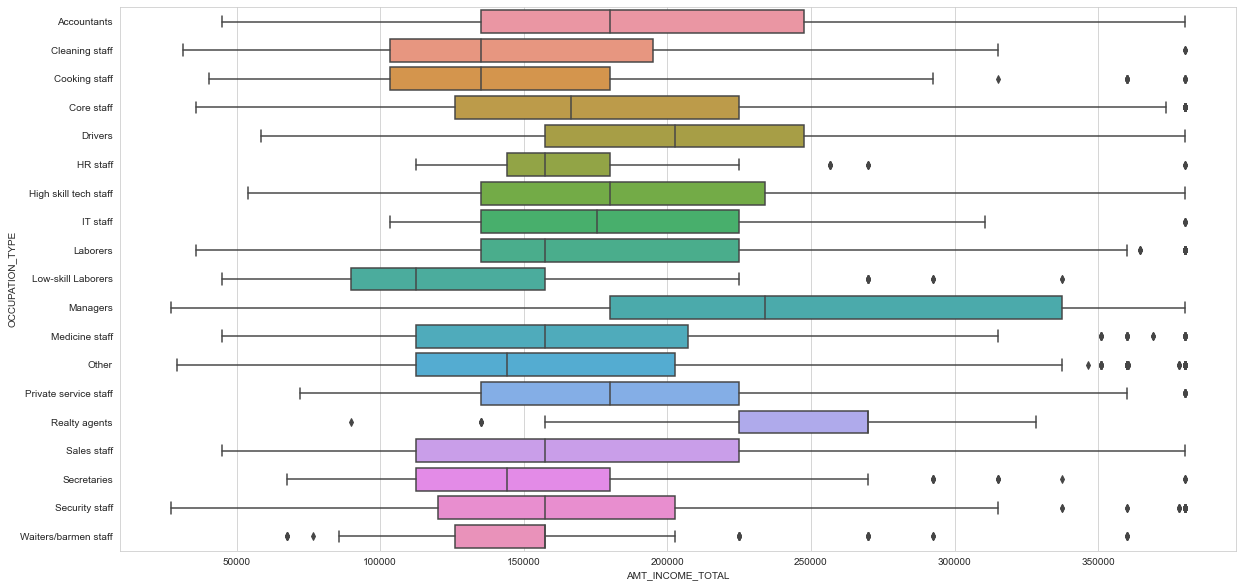

In [57]:
fig = plt.figure(figsize=(20,10))

sns.boxplot(data=merged_df, x="AMT_INCOME_TOTAL", y="OCCUPATION_TYPE")

plt.show()

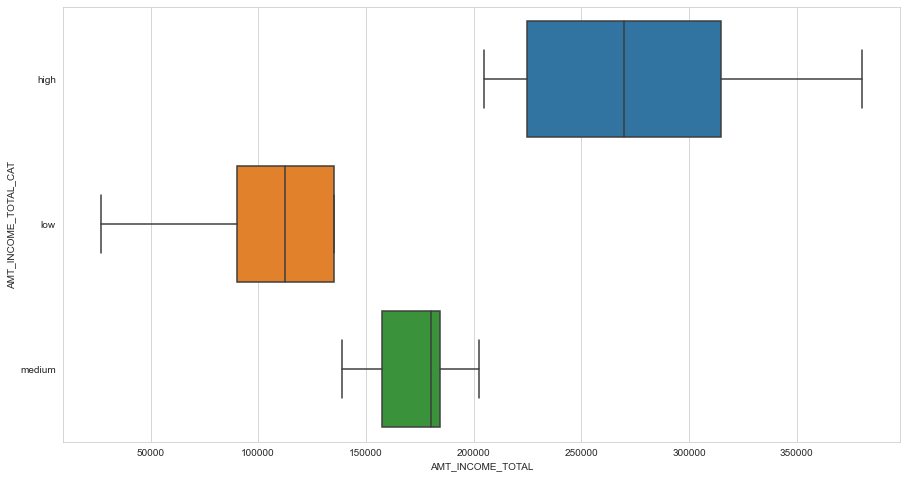

In [58]:
fig = plt.figure(figsize=(15,8))

sns.boxplot(data=merged_df, x="AMT_INCOME_TOTAL", y="AMT_INCOME_TOTAL_CAT")

plt.show()

##### Correlation

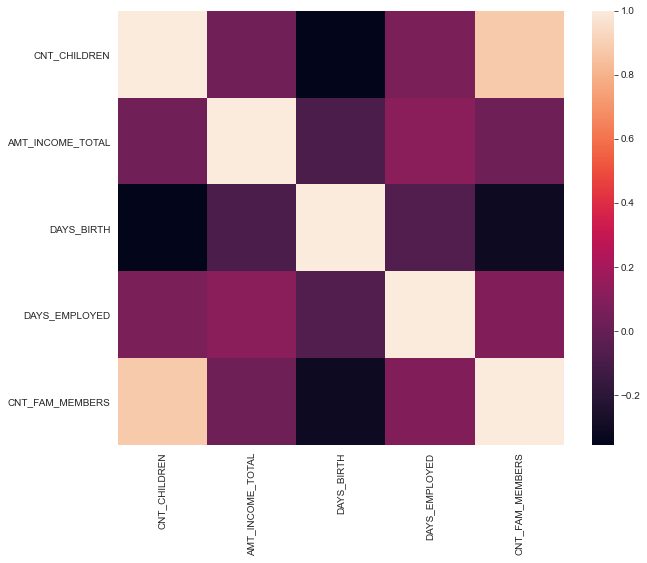

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS
CNT_CHILDREN,1.000000,0.033121,-0.357159,0.072050,0.878390
AMT_INCOME_TOTAL,0.033121,1.000000,-0.087343,0.114077,0.021687
DAYS_BIRTH,-0.357159,-0.087343,1.000000,-0.067711,-0.311964
DAYS_EMPLOYED,0.072050,0.114077,-0.067711,1.000000,0.084762
CNT_FAM_MEMBERS,0.878390,0.021687,-0.311964,0.084762,1.000000


In [59]:
corr = merged_df[num_features].corr()

fig = plt.figure(figsize=(10, 8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

corr

##### Scatter Plots

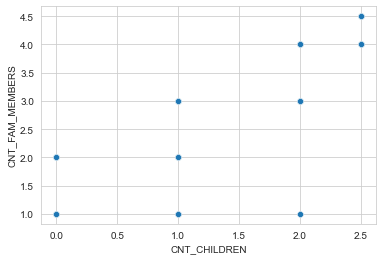

In [60]:
fig = plt.figure()

ax = sns.scatterplot(data=merged_df, x="CNT_CHILDREN", y="CNT_FAM_MEMBERS")

#ax.set_xticks(np.arange(start=0, stop=20, step=1))
#ax.set_yticks(np.arange(start=0, stop=20, step=1))
plt.show()

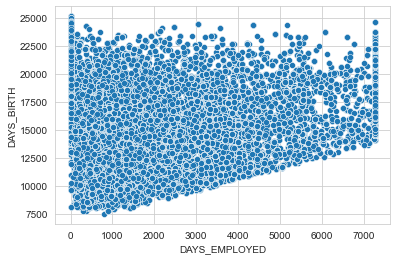

In [61]:
fig = plt.figure()

sns.scatterplot(data=merged_df, x="DAYS_EMPLOYED", y="DAYS_BIRTH")

plt.show()

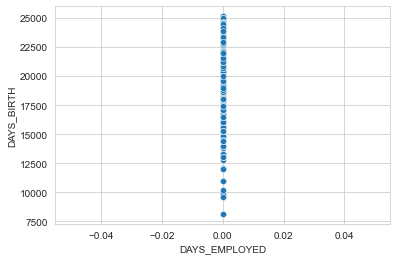

In [62]:
fig = plt.figure()

sns.scatterplot(data=merged_df[merged_df['DAYS_EMPLOYED']==0], x="DAYS_EMPLOYED", y="DAYS_BIRTH")

plt.show()

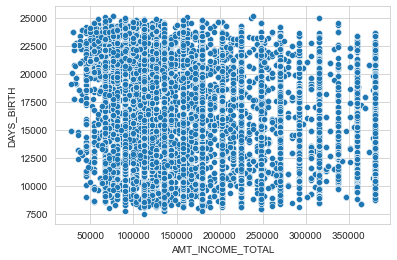

In [63]:
fig = plt.figure()

sns.scatterplot(data=merged_df, x="AMT_INCOME_TOTAL", y="DAYS_BIRTH")

plt.show()

##### Clustered Bar Charts

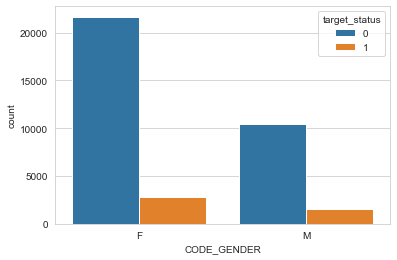

In [64]:
fig = plt.figure()

sns.countplot(data=merged_df, x="CODE_GENDER", hue="target_status")

plt.show()

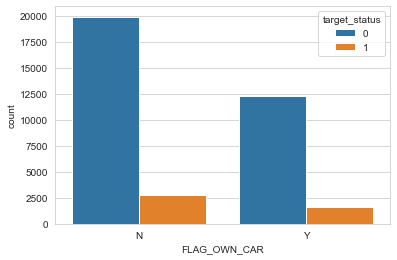

In [65]:
fig = plt.figure()

sns.countplot(data=merged_df, x="FLAG_OWN_CAR", hue="target_status")

plt.show()

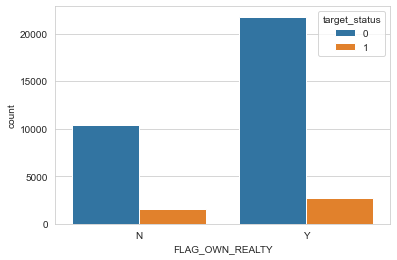

In [66]:
fig = plt.figure()

sns.countplot(data=merged_df, x="FLAG_OWN_REALTY", hue="target_status")

plt.show()

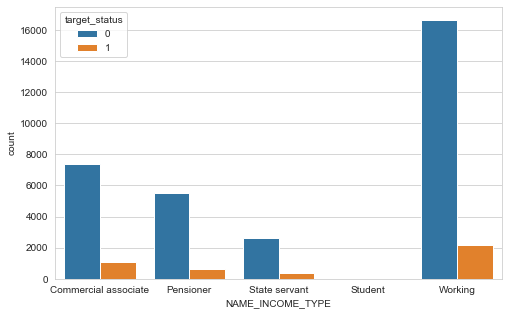

In [67]:
fig = plt.figure(figsize=(8,5))

sns.countplot(data=merged_df, x="NAME_INCOME_TYPE", hue="target_status")

plt.show()

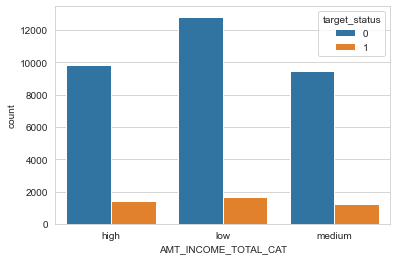

In [68]:
fig = plt.figure()

sns.countplot(data=merged_df, x="AMT_INCOME_TOTAL_CAT", hue="target_status")

plt.show()

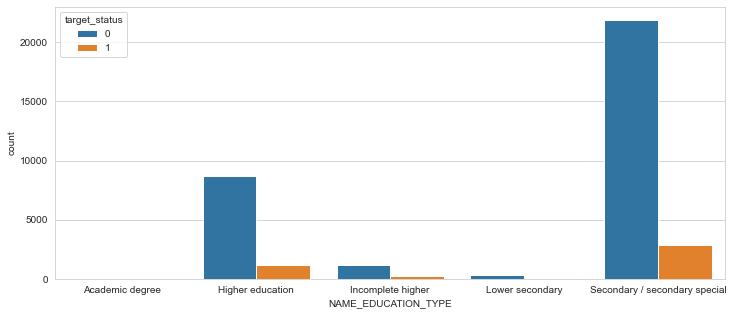

In [69]:
fig = plt.figure(figsize=(12,5))

sns.countplot(data=merged_df, x="NAME_EDUCATION_TYPE", hue="target_status")

plt.show()

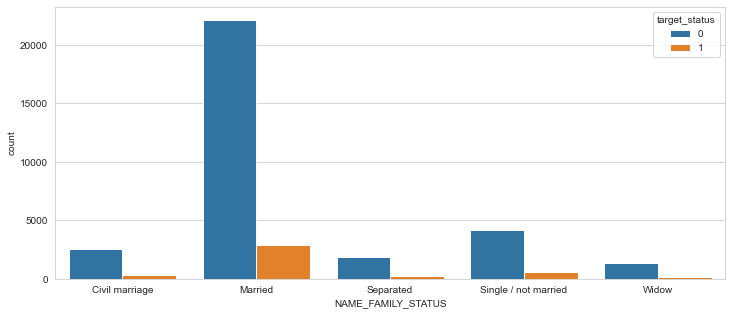

In [70]:
fig = plt.figure(figsize=(12,5))

sns.countplot(data=merged_df, x="NAME_FAMILY_STATUS", hue="target_status")

plt.show()

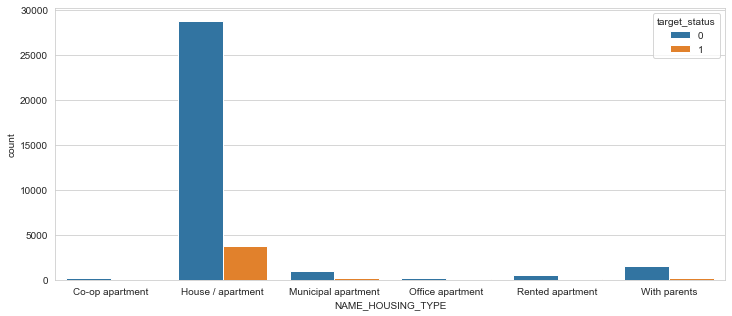

In [71]:
fig = plt.figure(figsize=(12,5))

sns.countplot(data=merged_df, x="NAME_HOUSING_TYPE", hue="target_status")

plt.show()

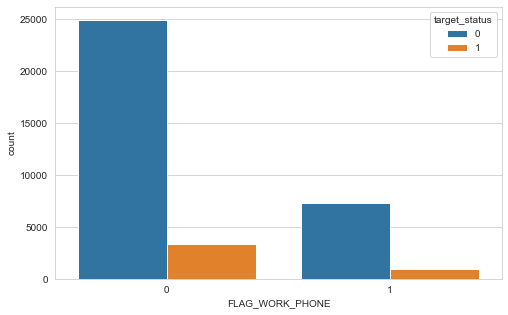

In [72]:
fig = plt.figure(figsize=(8,5))

sns.countplot(data=merged_df, x="FLAG_WORK_PHONE", hue="target_status")

plt.show()

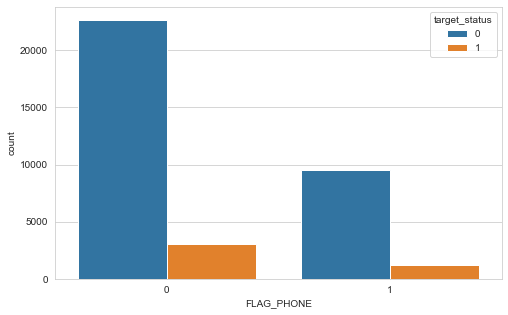

In [73]:
fig = plt.figure(figsize=(8,5))

sns.countplot(data=merged_df, x="FLAG_PHONE", hue="target_status")

plt.show()

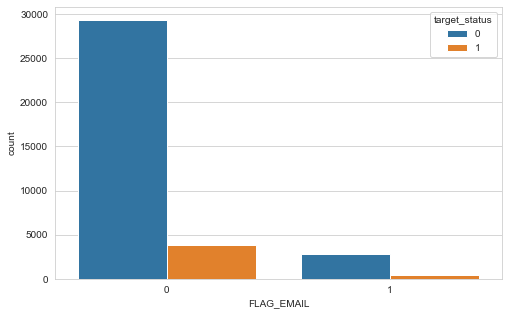

In [74]:
fig = plt.figure(figsize=(8,5))

sns.countplot(data=merged_df, x="FLAG_EMAIL", hue="target_status")

plt.show()

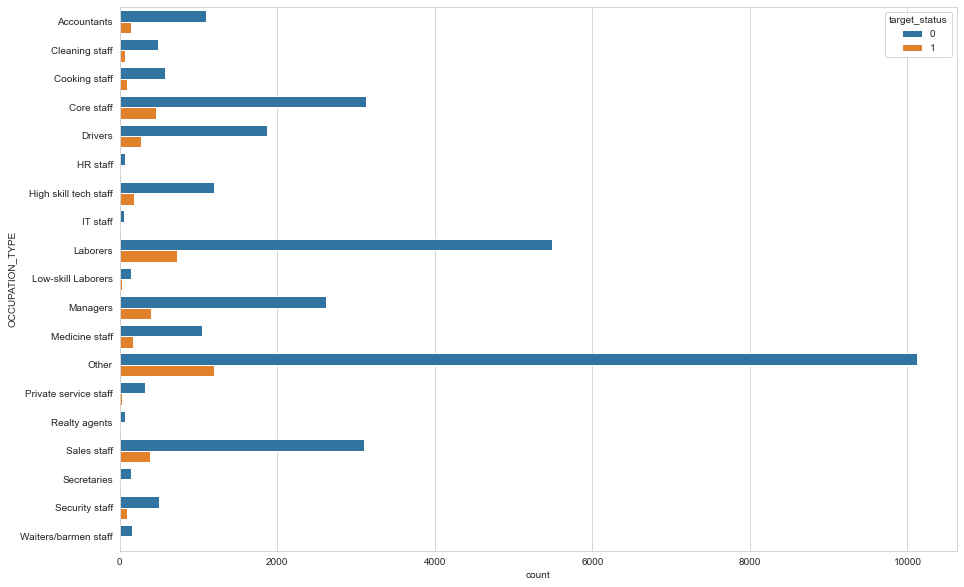

In [75]:
fig = plt.figure(figsize=(15,10))

sns.countplot(data=merged_df, y="OCCUPATION_TYPE", hue="target_status")

plt.show()

### Data Visualization - Multivariate Analysis

#### Bubble Chart

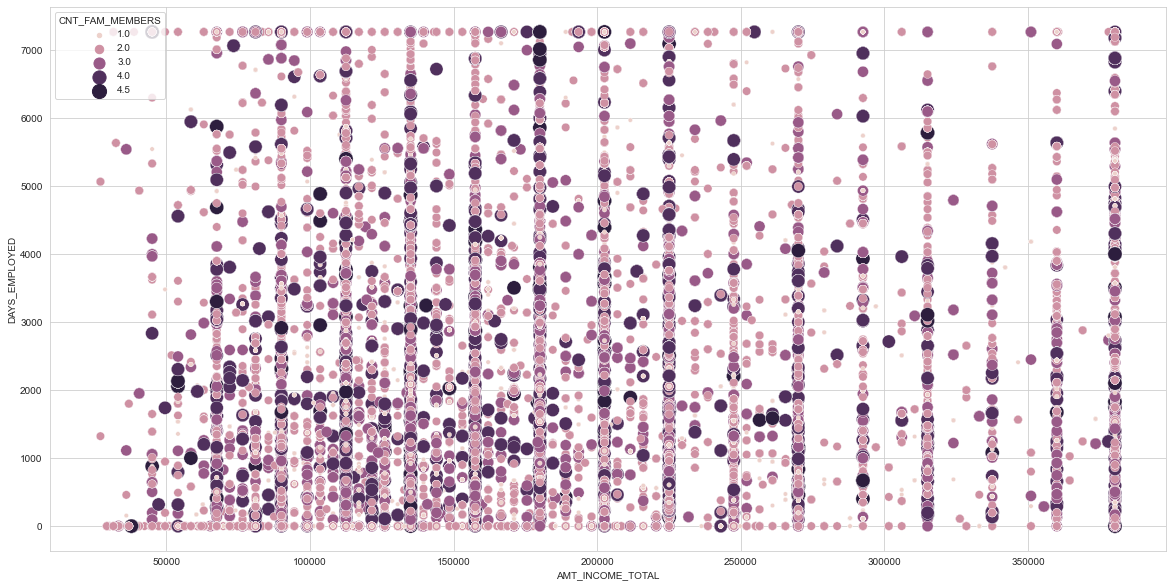

In [76]:
fig = plt.figure(figsize=(20,10))

sns.scatterplot(data=merged_df[merged_df['DAYS_EMPLOYED']>=0], x="AMT_INCOME_TOTAL", y="DAYS_EMPLOYED", size="CNT_FAM_MEMBERS", sizes=(20, 200), hue="CNT_FAM_MEMBERS")

plt.show()

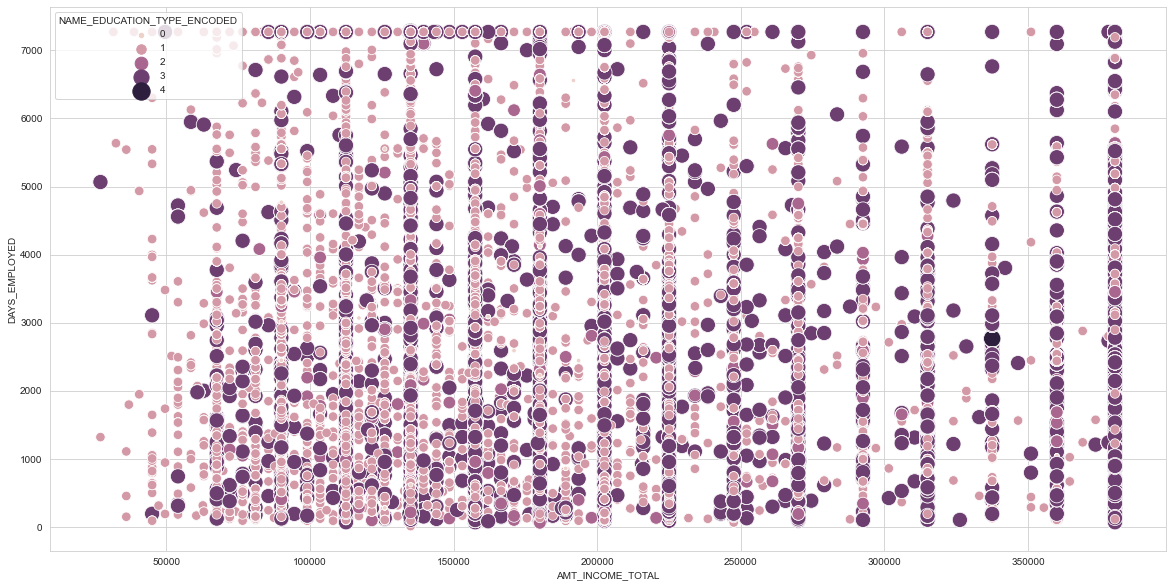

In [77]:
fig = plt.figure(figsize=(20,10))

sns.scatterplot(data=merged_df[merged_df['DAYS_EMPLOYED']>0],
                x="AMT_INCOME_TOTAL",
                y="DAYS_EMPLOYED",
                size="NAME_EDUCATION_TYPE_ENCODED",
                sizes=(20, 300),
                hue="NAME_EDUCATION_TYPE_ENCODED")

plt.show()

#### Pairplot

<Figure size 432x288 with 0 Axes>

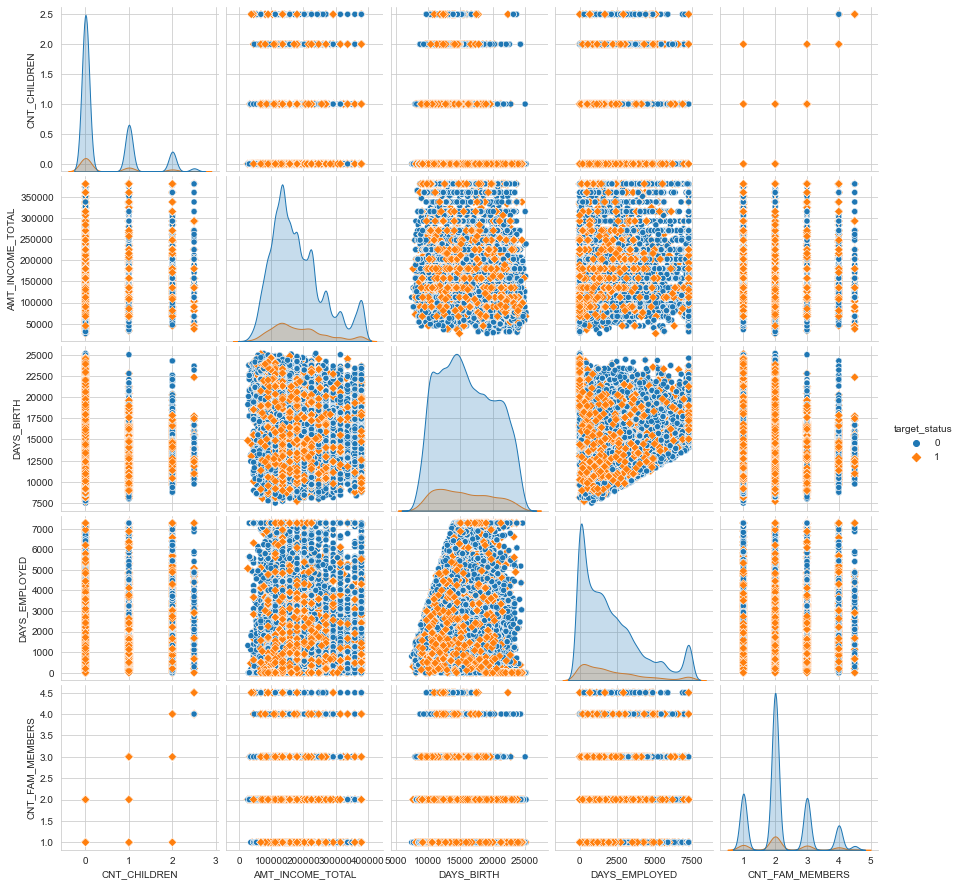

In [78]:
fig = plt.figure()

sns.pairplot(data=merged_df.drop(columns=['ID', 'NAME_EDUCATION_TYPE_ENCODED']), hue="target_status", markers=["o", "D"])

plt.show()